In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import datetime
from libs.sequences import SeismicSequence
from libs.iris import irisRequests
from libs.distributions import Weibull, WeibullMM, GaussianMM, InterTimeDistribution
from importlib import reload  # Python 3.4+
import matplotlib.pyplot as plt
from ntpp_utils import get_time_nll_loss

# Model

In [2]:
class GRUPointProcess(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_mixtures=1):
        super().__init__()
        self.rnn = nn.GRU(input_dim,hidden_dim,
                          num_layers=1,
                          batch_first=True)
        self.n_mixtures = n_mixtures
        if(self.n_mixtures==1):
            self.weibull_mod = nn.Sequential(
                nn.Linear(hidden_dim, 2),
                nn.Softplus()
            )
        else:
            self.weibull_mod = nn.Sequential(
                nn.Linear(hidden_dim, self.n_mixtures*2),
                nn.Softplus()
            )
            self.mixture_mod = nn.Sequential(
                nn.Linear(hidden_dim, self.n_mixtures),
                nn.Softmax(dim=-1)
            )
    def forward(self,x):
        rnn_output, _ = self.rnn(x) # (n_sequences ~ batch size, max_seq_length, hidden_dim )
        # shift forward along the time dimension and pad
        # so we can use it to model the inter times
        context = F.pad(rnn_output[:, :-1, :], (0,0, 1,0))
        weibull_params = self.weibull_mod(context)
        if(self.n_mixtures == 1):
            distr = Weibull(weibull_params[..., 0], weibull_params[..., 1])
        else:
            pip_params = self.mixture_mod(context)
            distr = WeibullMM(pip_params, weibull_params[..., :self.n_mixtures], weibull_params[..., self.n_mixtures:])
        return context, distr

# Data

In [3]:
# specify regions limits
regions = {}
regions['greece'] = (30, 45,18, 44)
regions['california'] = (30, 41, -125, -113)
regions['japan'] = (20, 50, 120, 150)
regions['italy'] = (35,46,6, 19)

In [4]:
load_cat = True
region_name = "japan"
region = regions[region_name]
if(load_cat):
    df = pd.read_csv("catalogs/" + region_name + ".csv", parse_dates=['Time'])
else:
    start_time = datetime.datetime(1980, 1, 1, 0, 0, 0)
    end_time =  datetime.datetime(2024, 1, 1, 0, 0, 0)
    download_url =irisRequests.url_events_box(start_time, end_time, region[0], region[1], region[2], region[3], minmag=3, magtype="MW")
    df = pd.read_csv(download_url, sep="|", comment="#")
    df.Time = pd.to_datetime(df.Time, errors='coerce')
    df.dropna(axis=0, inplace=True)
    df.sort_values(by="Time", inplace=True)
    df.reset_index(inplace=True, drop=True)
    df.to_csv("catalogs/japan.csv", index=False)

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_7692/3562696496.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("catalogs/" + region_name + ".csv", parse_dates=['Time'])


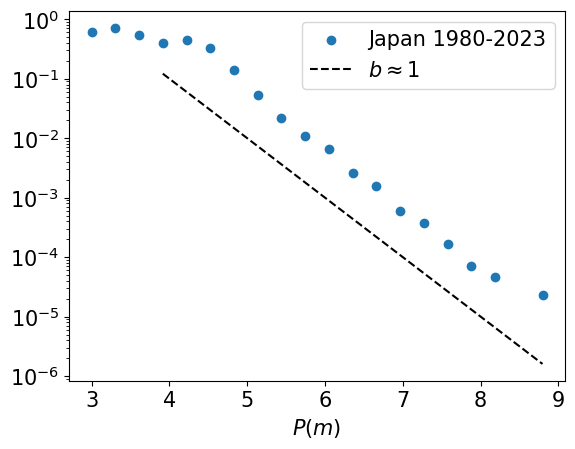

In [30]:
hist, edges = np.histogram(df.Magnitude, density=True, bins=20)
plt.scatter(edges[:-1], hist, label="Japan 1980-2023")
plt.plot(edges[3:-1],10**(-1.0*(edges[3:-1]-3)), ls='dashed', color='black', label='$b \\approx 1$')
plt.legend(fontsize=15)
plt.yscale('log')
plt.xlabel("$m$", fontsize=15)
plt.xlabel("$P(m)$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [5]:
train_sequences = SeismicSequence.from_pandas_df(df[df.Time < datetime.datetime(2012, 1, 1, 0, 0, 0, tzinfo=datetime.UTC)], unit='s')

NameError: name 'df' is not defined

# Training

In [8]:
model = GRUPointProcess(1, 10, n_mixtures=1)

In [9]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [10]:
epochs = 100
use_random_length = True
duration_days = 3
duration = 60*60*24*duration_days # in seconds
for epoch in range(epochs):
    print(epoch)
    with torch.no_grad():
        seqs = []
        t_start = duration
        max_t_end = train_sequences.t_end
        while(True):
            if(use_random_length):
                t_end = t_start + np.random.exponential()*duration
            else:
                t_end = t_start + duration
            if(t_end > max_t_end):
                break
            sub_seq = train_sequences.get_subsequence(t_start, t_end)
            if(len(sub_seq.arrival_times) > 0):
                seqs.append(sub_seq)
            t_start = t_end
        inter_times, features, lengths = SeismicSequence.pack_sequences(seqs) 
    optimizer.zero_grad()
    input_time_features = inter_times.unsqueeze(-1)
    context, distr = model(input_time_features)
    loss = get_time_nll_loss(inter_times, lengths, distr).mean()
    loss.backward()
    optimizer.step()
    print(loss.item())

0
6669.27880859375
1
6948.095703125
2
6314.42333984375
3
6199.8271484375
4
6256.56640625
5
5857.1787109375
6
5814.26171875
7
5394.23193359375
8
5372.42822265625
9
5309.64111328125
10
4909.232421875
11
4873.53369140625
12
4884.2998046875
13
4454.9130859375
14
4729.7685546875
15
4333.6181640625
16
4252.6962890625
17
4182.365234375
18
4077.15087890625
19
3938.952880859375
20
3723.66259765625
21
1784.9522705078125
22
1558.4620361328125
23
1515.844482421875
24
1426.73388671875
25
1408.40673828125
26
1424.260498046875
27
1390.0526123046875
28
1349.705078125
29
1363.6051025390625
30
1351.8634033203125
31
1337.99560546875
32
1323.8087158203125
33
1303.995361328125
34


KeyboardInterrupt: 